# HadISST Data Set

In [1]:
from datetime import date, datetime, timedelta

import netCDF4 as nc
import numpy as np
import scipy.signal
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm

## Loading the dataset
I am using the sea surface temperature data from the Hadley Center Sea Surface Temperature data set (HadISST) available here:
https://www.metoffice.gov.uk/hadobs/hadisst/index.html

I downloaded the data in NetCDF format from here:
https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html

In [2]:
ds = nc.Dataset("../data/01_raw/HadISST_sst.nc")
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Title: Monthly version of HadISST sea surface temperature component
    description: HadISST 1.1 monthly average sea surface temperature
    institution: Met Office Hadley Centre
    source: HadISST
    reference: Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., Kent, E. C., Kaplan, A.  Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670
    Conventions: CF-1.0
    history: 21/3/2022 converted to netcdf from pp format
    supplementary_information: Updates and supplementary information will be available from http://www.metoffice.gov.uk/hadobs/hadisst
    comment: Data restrictions: for academic research use only. Data are Crown copyright see (http://www.opsi.gov.uk/advice/crown-copyright/copyright-guidance/index.htm

In [3]:
first_date = date(1870, 1, 1)
last_date = first_date + timedelta(days=ds["time_bnds"][-1, 1].item())
print(f"Data covers {first_date} to {last_date}")

Data covers 1870-01-01 to 2022-02-01


In [4]:
SST_ICE_VAL = -1000

In [5]:
sst_expanded = ds["sst"][...]
is_ice = (sst_expanded == SST_ICE_VAL).filled(False)  # 100% sea-ice
min_temp = np.nanmin(sst_expanded[~is_ice])
max_temp = np.nanmax(sst_expanded[~is_ice])

print(f"Temperature range: {min_temp:.2g}°C to {max_temp:.2g}°C")

Temperature range: -1.8°C to 35°C


## Geographical plots
We can plot the sea surface temperature data for a given month as a contour plot. We use the same colours for temperatures across all time points.

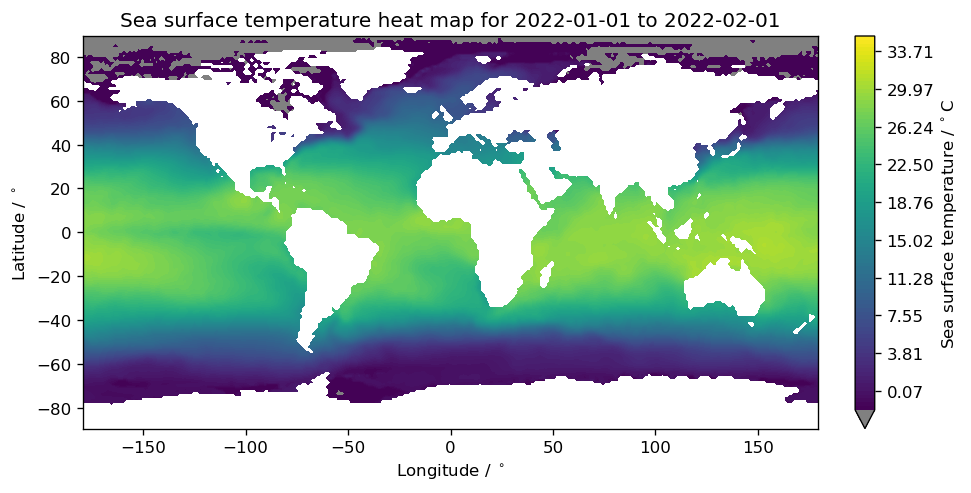

In [6]:
t_ix = -1  # Time index (i.e. choose month to plot)

fig, ax = plt.subplots(figsize=(8, 4), dpi=120, constrained_layout=True)

cmap = mpl.cm.get_cmap("viridis").with_extremes(under="gray")
h = ax.contourf(
    np.asarray(ds["longitude"]),
    np.asarray(ds["latitude"]),
    ds["sst"][t_ix].filled(np.nan),
    levels=np.linspace(min_temp-1e-6, max_temp+1e-6, 100),
    vmin=min_temp,
    vmax=max_temp,
    cmap=cmap,
    extend="min",
)
fig.colorbar(h, label="Sea surface temperature / $^\\circ\\mathrm{C}$")

ax.set_xlabel("Longitude / $^\\circ$")
ax.set_ylabel("Latitude / $^\\circ$")
ax.set_title(
    "Sea surface temperature heat map for {} to {}".format(
        first_date + timedelta(days=ds["time_bnds"][t_ix, 0].item()),
        first_date + timedelta(days=ds["time_bnds"][t_ix, 1].item())
    )
);

## Time-series plots

In [7]:
ix_lat, ix_long = 41, 174
print("Coordinates:", (float(ds["latitude"][ix_lat])), float(ds["longitude"][ix_long]))

Coordinates: 48.5 -5.5


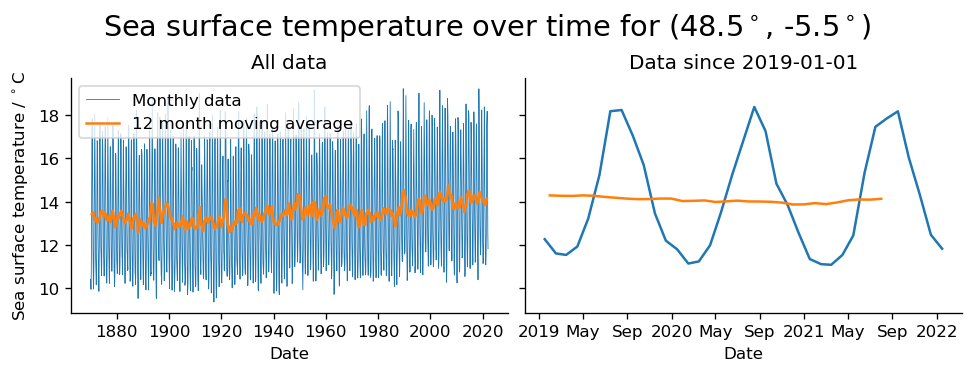

In [8]:
def to_numpy_datetimes(offset_days, first_date):
    return np.datetime64(first_date) + offset_days.astype("timedelta64[D]")

def moving_av(x, width):
    return np.convolve(x, np.ones(width), "valid") / width

def plot_sst_ts(ds, sst, ix_lat, ix_long, title=None):
    t = to_numpy_datetimes(ds["time"][:], first_date)
    sst_ = sst[:, ix_lat, ix_long]
    t_av = to_numpy_datetimes(moving_av(ds["time"][:], 12), first_date)
    sst_av = moving_av(sst_, 12)

    fig, axs = plt.subplots(
        1, 2,
        sharey=True,
        figsize=(8, 3), dpi=120,
        constrained_layout=True,
    )

    axs[0].plot(t, sst_, linewidth=0.5, label="Monthly data")
    axs[0].plot(t_av, sst_av, label="12 month moving average")
    axs[0].legend()

    cutoff = date(2019, 1, 1)
    axs[1].plot(t[t >= cutoff], sst_[t >= cutoff], label="Monthly data")
    axs[1].plot(t_av[t_av >= cutoff], sst_av[t_av >= cutoff], label="12 month moving average")

    for ax in axs:
        locator = mpl.dates.AutoDateLocator()
        formatter = mpl.dates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

        ax.spines[["top", "right"]].set_visible(False)

    for ax in axs:
        ax.set_xlabel("Date")
    axs[0].set_ylabel("Sea surface temperature / $^\\circ\\mathrm{C}$")
    axs[0].set_title("All data")
    axs[1].set_title(f"Data since {cutoff}")
    
    if not title:
        title = "Sea surface temperature over time"
    fig.suptitle(
        f"{title} for ({float(ds['latitude'][ix_lat])}$^\\circ$, {float(ds['longitude'][ix_long])}$^\\circ$)",
        fontsize="xx-large",
    )


plot_sst_ts(ds, ds["sst"][:], ix_lat, ix_long);

# Anomaly time series
To generate our so-called anomaly time series, we:
  - Remove a linear trend from all time series
  - Remove the annual seasonality from all time series
  - Apply a low-pass Lanczos filter with a cutoff frequency of 1/13 per month and order 144 (`window_length = 1 + 2 * (order - 1)`)

In [9]:
def detrend(t, y):
    """Remove a linear trend from masked data"""
    assert y.ndim == 3
    
    has_masked_values = y.mask.any(axis=0)
    all_masked_values = y.mask.all(axis=0)
    
    y_detrend = y.copy()
    
    # First handle most of the locations together (the ones without masked
    # values). We don't do everything in the for loop since this is slow.
    t_mat = np.stack([t, np.ones_like(t)], axis=-1)
    t_mat = _unmask_safe(t_mat)
    y_not_masked = _unmask_safe(y[:, ~has_masked_values])
    beta, _, _, _ = np.linalg.lstsq(t_mat, y_not_masked, rcond=None)
    
    y_detrend[:, ~has_masked_values] -= t_mat @ beta
    
    # Then handle the ones with masked values
    for i, j in tqdm(np.argwhere(has_masked_values & ~all_masked_values)):
        mask = y[:, i, j].mask
        t_ = t[~mask]
        y_ = y[~mask, i, j]
        t_mat = np.stack([t_, np.ones_like(t_)], axis=-1)
        beta, _, _, _ = np.linalg.lstsq(t_mat, y_, rcond=None)
        y_detrend[~mask, i, j] -= t_mat @ beta
    
    return y_detrend


def _unmask_safe(arr):
    if np.ma.is_masked(arr):
        raise ValueError("arr has masked values!")
    return arr.filled()  # Fill value doesn't matter since not masked

    
def remove_seasonal(y):
    """Remove annual seasonality from masked data"""
    n_pts = len(y)
    y_bymonth = [[] for _ in range(12)]
    for i in range(n_pts):
        y_bymonth[i % 12].append(y[i])
    seas_avg = [sum(y_) / len(y_) for y_ in y_bymonth]
        
    y_noseas = y.copy()
    for i in range(n_pts):
        y_noseas[i] -= seas_avg[i%12]
    
    return y_noseas

In [10]:
print("Detrending")
sst_detrend = detrend(ds["time"][:], np.ma.masked_where(is_ice, sst_expanded))

print("Removing seasonal components")
sst_noseas = remove_seasonal(sst_detrend)

print("Replacing sea ice values")
sst_noseas[is_ice] = SST_ICE_VAL

# TODO: Apply Lanczos low pass filter

print("Done")

Detrending


100%|██████████| 9719/9719 [00:04<00:00, 2035.80it/s]


Removing seasonal components
Replacing sea ice values
Done


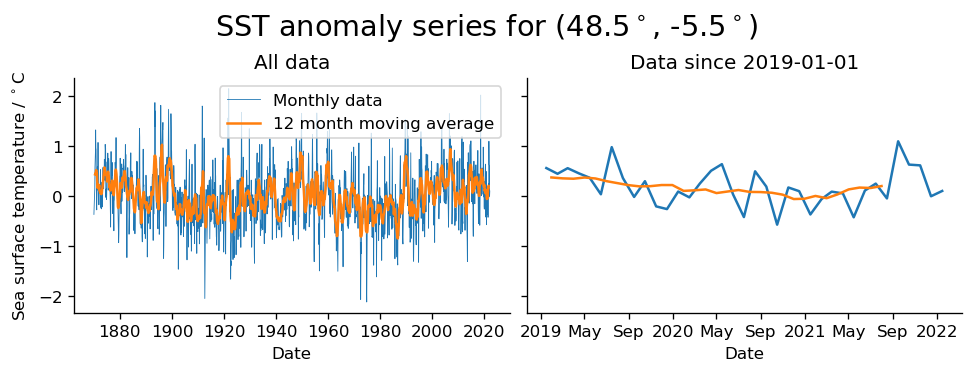

In [11]:
plot_sst_ts(ds, sst_noseas, ix_lat, ix_long, title="SST anomaly series");